This tutorial is adapted from [**Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras** by Jason Brownlee (2016)](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

In [1]:
%matplotlib inline

import keras.layers
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.preprocessing
import seaborn as sns; sns.set_theme()

np.random.seed(0)

def rolling_window(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

Let's begin by downloading and plotting the data set, which documents the number of airline passengers (in units of 1,000) per month.

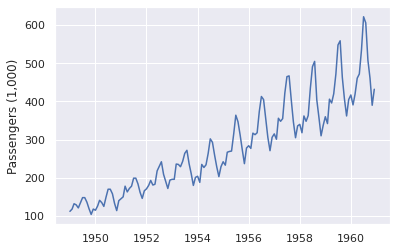

In [2]:
dataf = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")
dataf["Time"] = pd.to_datetime(dataf["Month"], utc=True)

plt.close("all")
fig, ax = plt.subplots()
ax.plot(dataf["Time"], dataf["Passengers"])
ax.set_label("Time")
ax.set_ylabel("Passengers (1,000)");

Now let's rescale the data to lie between 0 and 1.

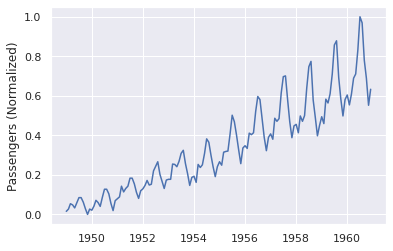

In [3]:
v = dataf[["Passengers"]].astype(np.float32).values
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
dataf["Passengers (Normalized)"] = scaler.fit_transform(v)

plt.close("all")
fig, ax = plt.subplots()
ax.plot(dataf["Time"], dataf["Passengers (Normalized)"]);
ax.set_label("Time")
ax.set_ylabel("Passengers (Normalized)");

Let's also split our data set into training and test data sets. We will use 2/3 of the data for training and 1/3 for testing.

In [4]:
train_size = int(len(v) * 2/3)
dataf.loc[: train_size, "Label"] = "Train"
dataf.loc[train_size: , "Label"] = "Test"

v_train = dataf.set_index("Label").loc["Train", "Passengers (Normalized)"].values
v_test = dataf.set_index("Label").loc["Test", "Passengers (Normalized)"].values

No we will create the feature (X) and the target (y) data sets. A fixed number of past samples will be used to predict the next sample value. The number of past samples to use is defined by `n_features`. To begin, we will use a single past sample to predict the next sample.

In [22]:
n_features = 1

X_train = rolling_window(v_train, n_features)[:-1]
y_train = v_train[n_features: ]
X_test = rolling_window(v_test, n_features)[:-1]
y_test = v_test[n_features: ]

Now we can actually build and fit the LSTM model. We will use 4 LSTM blocks.

In [6]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(4, input_shape=(n_features, 1)))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)

Compute the misfit of the model predictions.

In [21]:
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.flatten().reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))

y_test_pred = scaler.inverse_transform(y_test_pred.flatten().reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

train_norm = np.linalg.norm(y_train - y_train_pred)
test_norm = np.linalg.norm(y_test - y_test_pred)

print(f"l2 misfit of training data: {train_norm:.3f}")
print(f"l2 misfit of test data: {test_norm:.3f}")

dataf = dataf.set_index("Label")
dataf.loc["Train", "Predicted"] = np.append(y_train_pred, np.repeat(np.nan, n_features))
dataf.loc["Test", "Predicted"] = np.append(y_test_pred, np.repeat(np.nan, n_features))
dataf = dataf.reset_index()

l2 misfit of training data: 253.795
l2 misfit of test data: 426.006



Finally, plot the predictions against the observations.

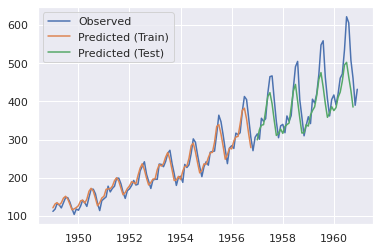

In [13]:
plt.close("all")
fig, ax = plt.subplots()

try:
  dataf = dataf.set_index("Label")

  ax.plot(dataf["Time"], dataf["Passengers"], label="Observed")
  for label in ("Train", "Test"):
      ax.plot(dataf.loc[label, "Time"], dataf.loc[label, "Predicted"], label=f"Predicted ({label})")
finally:
  dataf = dataf.reset_index()

ax.legend();

Try changing the number of features `n_features` above, and see how the prediction accuracy changes.